# Laplacian Associative Memory (LAM) - DEV 05

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

- SOM Orientation Preference

In [1]:
from nn import LAM
from libtools import *

In [2]:
import PIL.Image, itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# np.random.seed(123)

---

#### LOAD DATA

In [4]:
# # IMAGE
# FILENAME = "../data/images/kingfisher_resized.png"
# src = PIL.Image.open(FILENAME)
# src = np.array(src, dtype=float) / np.max(src)

In [5]:
# MNIST L2 WEIGHTS
# src = np.load('../data/weights/MNIST_l2.npy').T

In [6]:
# SOM ORIENTATION
src = np.load('../data/weights/SOM_orient.npy')
src = downsample_matrix(src, 5)

(41, 41, 3)


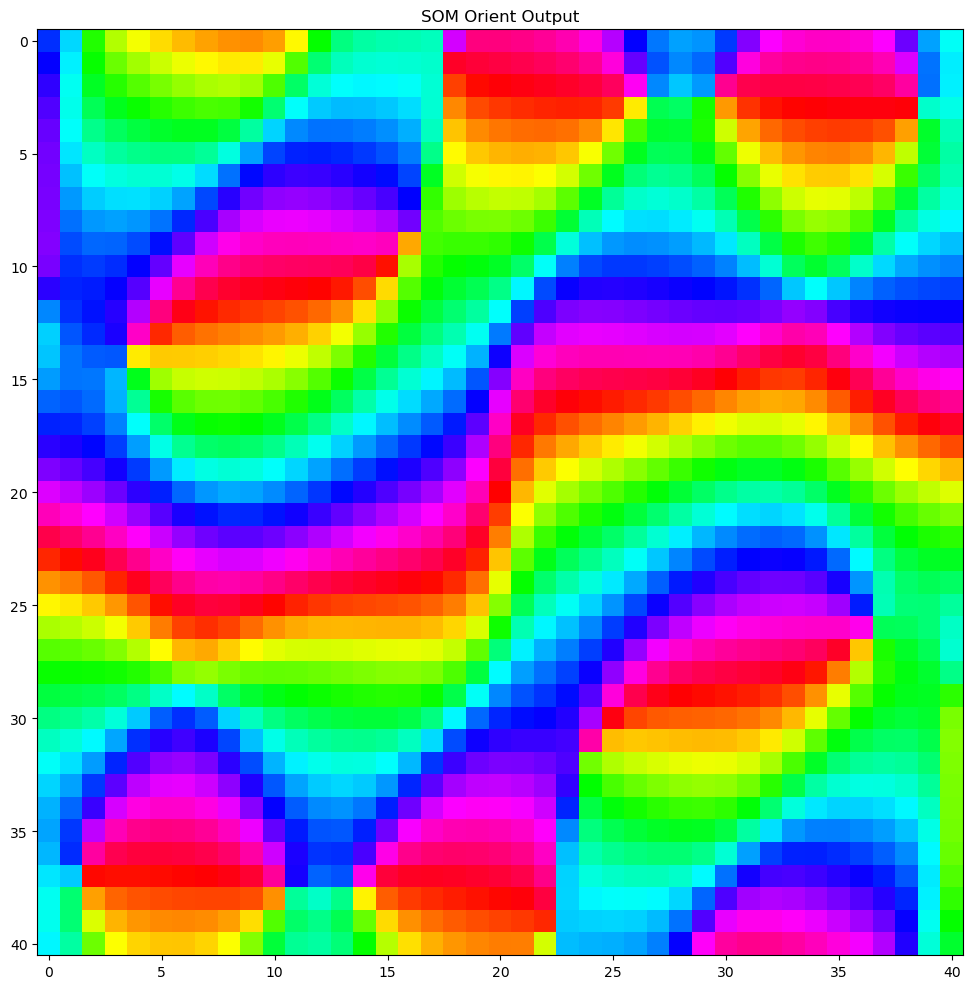

In [7]:
plt.figure(figsize=(30,10))
plt.imshow(src)
plt.title('SOM Orient Output')
plt.tight_layout()
print(src.shape)

---

#### CONSTRUCT GRAPH

Each pixel is regarded as a node and link weights are determined by spatial proximity, similarity of RGB values and orientation response.

In [8]:
def grad_filter(deg, samples, min=-1, max=1):
    gradient = np.linspace(min, max, samples)
    X, Y = np.meshgrid(gradient, gradient)
    rad = np.deg2rad(deg)
    grad = np.cos(rad) * X + np.sin(rad) * Y
    return grad

In [9]:
def convolve(image, kernel):
    h, w = image.shape
    step = kernel.shape[0]
    pad_img = np.pad(image, pad_width=step//2, mode='edge')
    features = np.array([[np.sum(pad_img[j:j+step, i:i+step] * kernel) for i in range(w)] for j in range(h)])
    return features

In [10]:
k = np.sum(src, axis=2)/3

features_x = convolve(k, grad_filter(0, 3))
features_y = convolve(k, grad_filter(90, 3))

mag = np.sqrt(features_x ** 2 + features_y ** 2)
dir = np.arctan2(features_y, features_x) # Arc-tangent of the ratio between x & y. Returning the correct angle between -π to π. (Direction of gradient)
features = mag * dir

features += abs(features.min())
features /= np.max(features)

Text(0.5, 1.0, 'Activation Map')

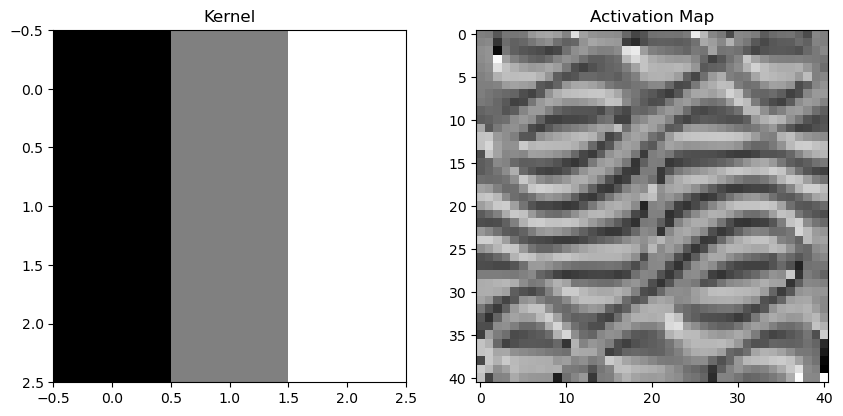

In [11]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(grad_filter(0, 3), 'gray')
plt.title('Kernel')
plt.subplot(1,2,2)
plt.imshow(features, 'gray')
plt.title('Activation Map')

In [12]:
n_row, n_col = src.shape[0], src.shape[1] # Input rows and columns
P = n_row * n_col # N_nodes

r = 5 # Search/boundary radius

sigmaI = 0.1 # Intensity gaussian scale
sigmaX = 4.0 # Spatial gaussian scale

enableOrient = True
sigmaTheta = 1.0 # Orientation gaussian scale

# Build list of pixel relationships
tmp = itertools.product(range(n_row), range(n_col)) # All possible pairs of column and row indicies [0,0] ... [34,34]
combi_all = itertools.combinations(tmp, 2) # Take the indices and build a combination of pairs for comparing two locations against each other [(0,0), (0,1)] ... [(34,34), (34,34)])
combi = [x for x in combi_all if np.sqrt((x[0][0] - x[1][0])**2 + (x[0][1] - x[1][1])**2) < r] # Calculate the euclidian distance for each two-pair(x) and if the distance is below radius (r), add x to the list combi.

edgelist_w = [] # Malloc
for x1, x2 in combi:
    n1 = int(x1[0] * n_col + x1[1]) # Compute the flattened position on the grid for x1
    n2 = int(x2[0] * n_col + x2[1]) # Compute the flattened position on the grid for x2

    # Solve similarity link weights | Shi & Marik (2000) - Default: Intensity & Spatial Domain
    intensity = np.exp(-np.sum((src[x1[0],x1[1]] - src[x2[0],x2[1]])**2) / (sigmaI**2))
    spatial = np.exp(-((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) / (sigmaX**2))

    if enableOrient == True:
        orientation = np.exp(-np.sum((features[x1[0],x1[1]] - features[x2[0],x2[1]])**2) / (sigmaTheta**2))
        simval = intensity * spatial * orientation
    else:    
        simval = intensity * spatial

    edgelist_w.append((n1, n2, simval)) # Populate edgelist with neuron position (n1, n2) and simval

# Construct adjacency matrix, every symmetric node in the graph is equal to the corresponding simval
W = np.zeros([P, P])
for x in edgelist_w:
    W[x[0],x[1]] = x[2]
    W[x[1],x[0]] = x[2]

Nnode= 1681 Nedge= 51698
231.98 point attactors
12407.52 bit capacity


Text(0.5, 1.0, 'Adjacency Weight Matrix')

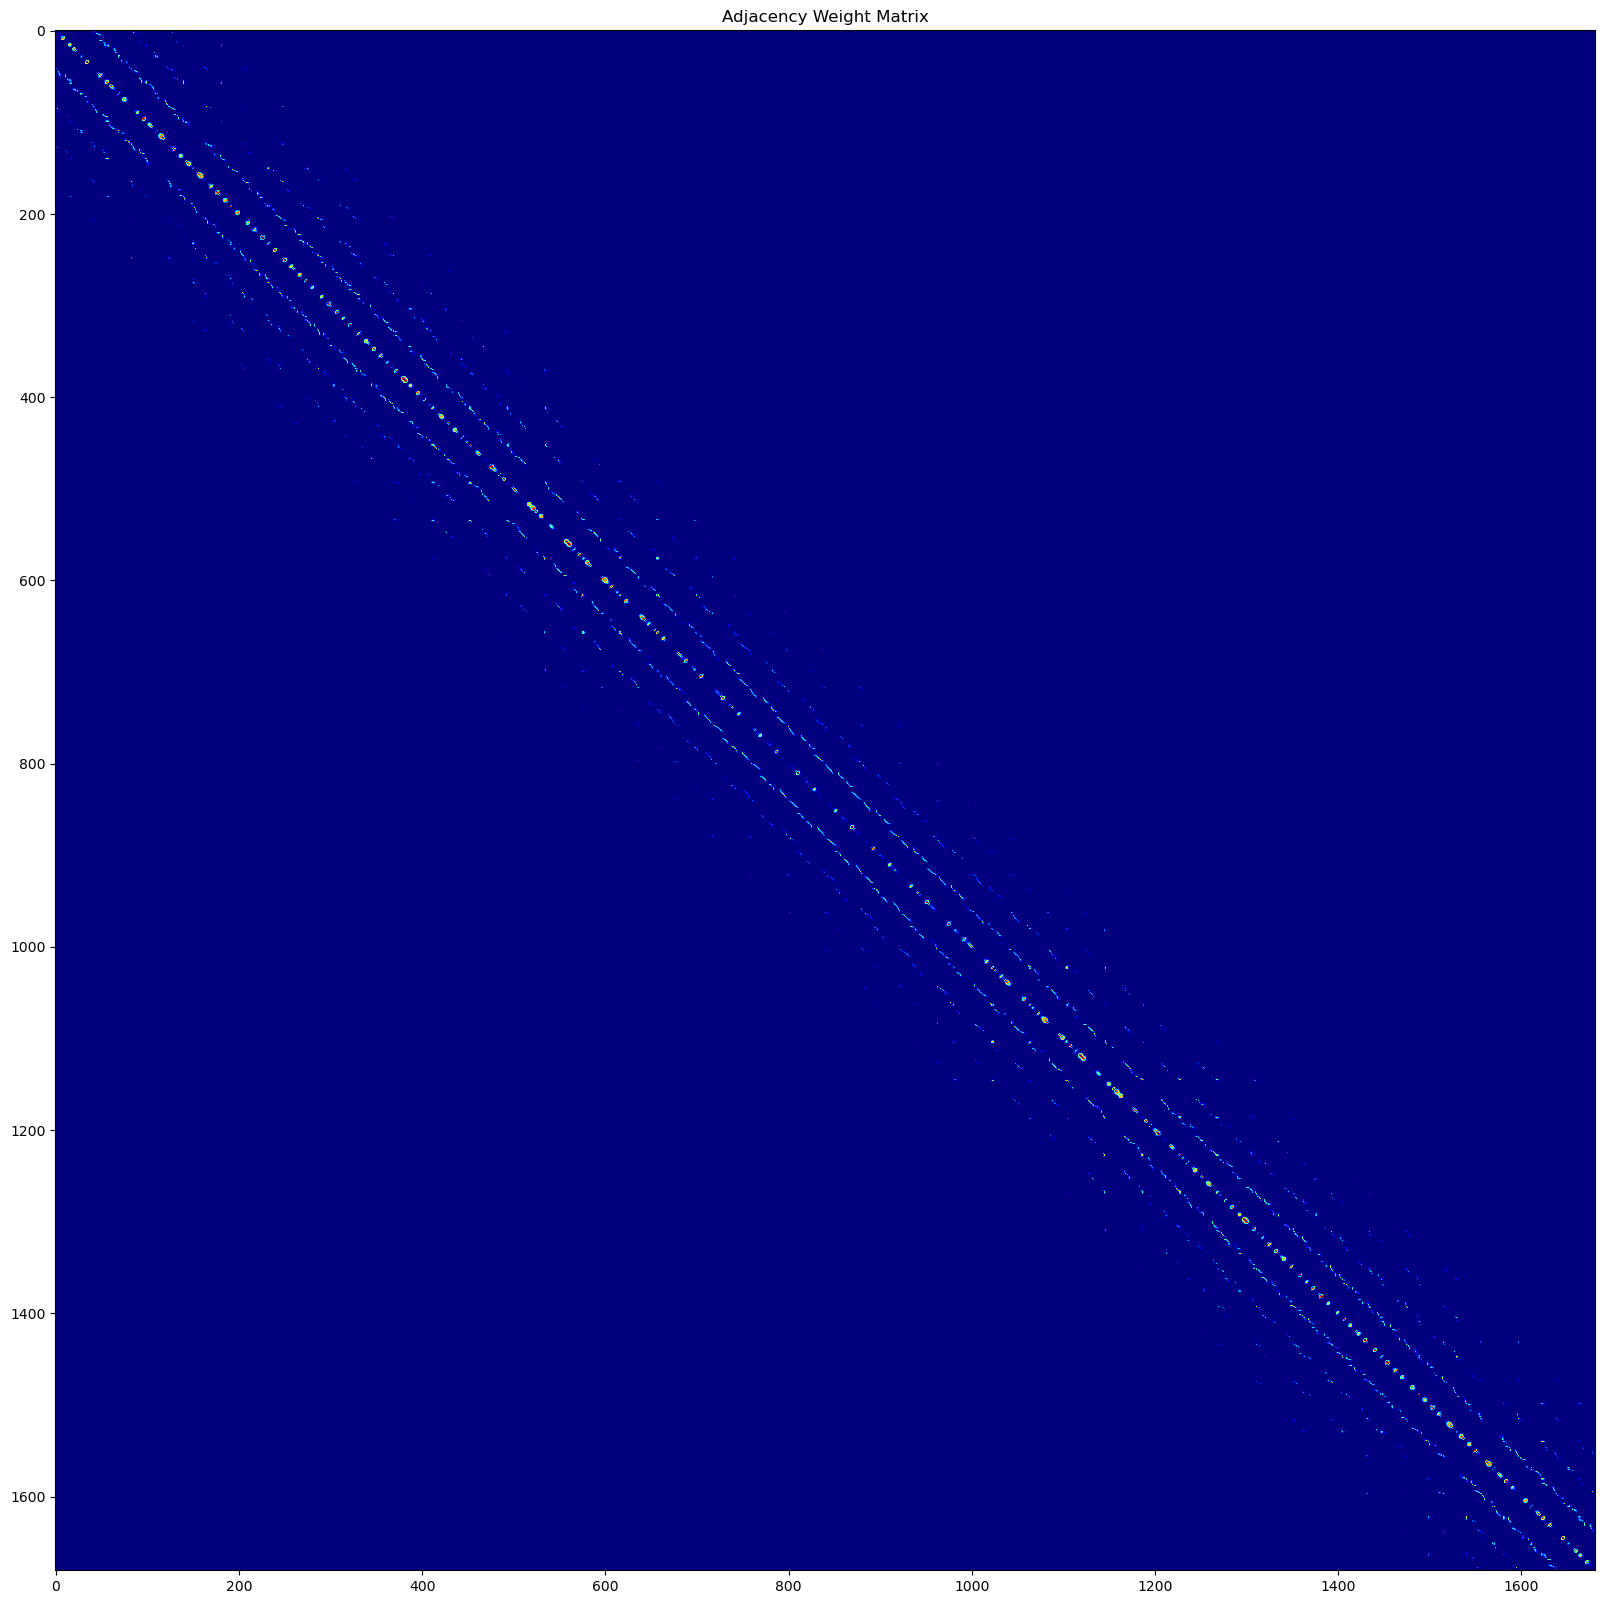

In [13]:
# Summary
print("Nnode=", P, "Nedge=", len(edgelist_w))
print(f"{P * 0.138:.2f} point attactors")
print(f"{0.24 * len(edgelist_w):.2f} bit capacity")

plt.figure(figsize=(20,20))
plt.imshow(W, cmap='jet')
plt.title('Adjacency Weight Matrix')

---

#### LAPLACIAN & EIGENVECTORS

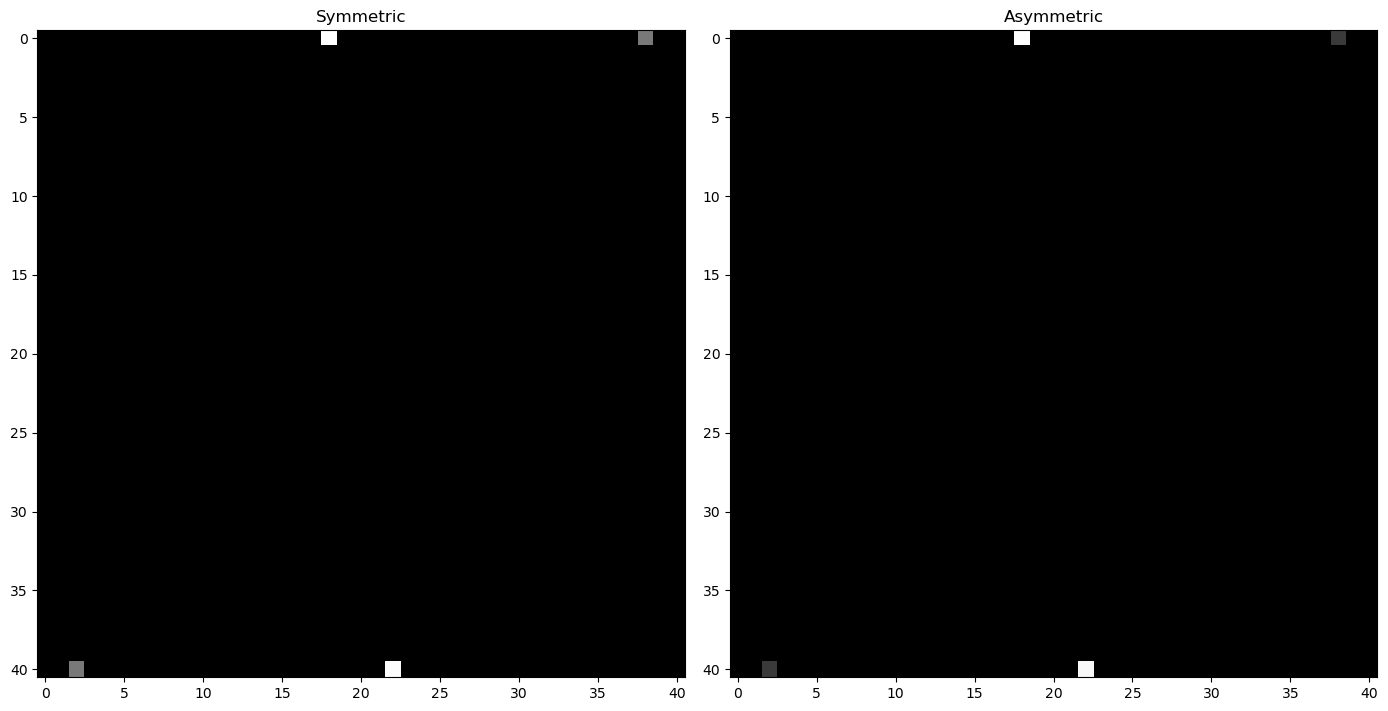

In [14]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
Dnorm_sym = np.diag(np.sum(W, axis=1)**-0.5) # SYMMETRIC normalized degree matrix
plt.imshow(np.sum(Dnorm_sym, axis=1).reshape(n_row,n_col), cmap='gray')
plt.title('Symmetric')

plt.subplot(1,2,2)
Dnorm_asym = np.diag(np.sum(W, axis=1)**-1) # ASYMMETRIC normalized degree matrix
plt.imshow(np.sum(Dnorm_asym, axis=1).reshape(n_row,n_col), cmap='gray')
plt.title('Asymmetric')
plt.tight_layout()

In [15]:
# Eigen Laplacian - ASYMMETRIC
L = np.eye(P) - Dnorm_asym @ W
e, v = np.linalg.eig(L)
e = np.real(e)
v = np.real(v)
order = np.argsort(e)
e = e[order]
v = v[:,order]

L | Min: -1.0 Max: 1.0


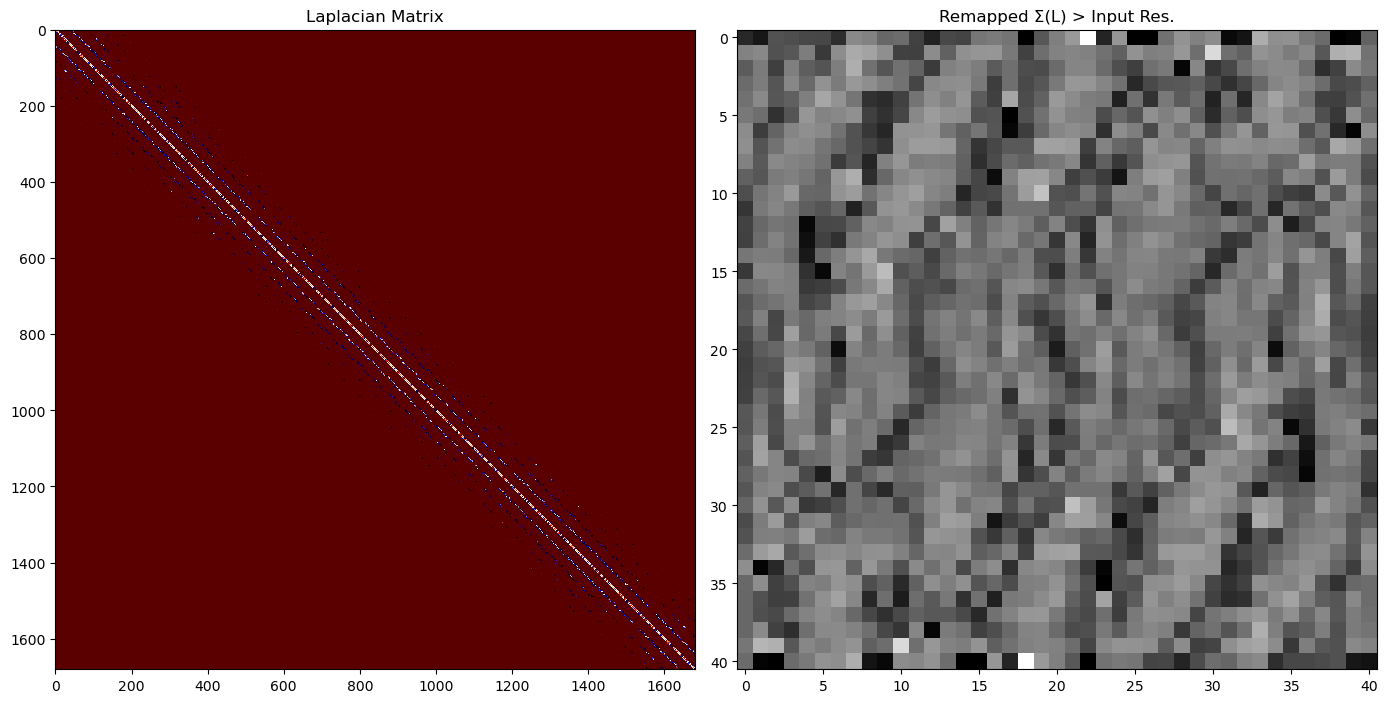

In [16]:
# Laplacian matrix
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(L, cmap='flag')
plt.title('Laplacian Matrix')

# Remapped sum of L matrix to input resolution
plt.subplot(1,2,2)
plt.imshow(np.sum(L, axis=0).reshape(n_row,n_col), cmap='binary')
plt.title('Remapped Σ(L) > Input Res.')
plt.tight_layout()

print('L | Min:', round(L.min(), 2), 'Max:', round(L.max(), 2))

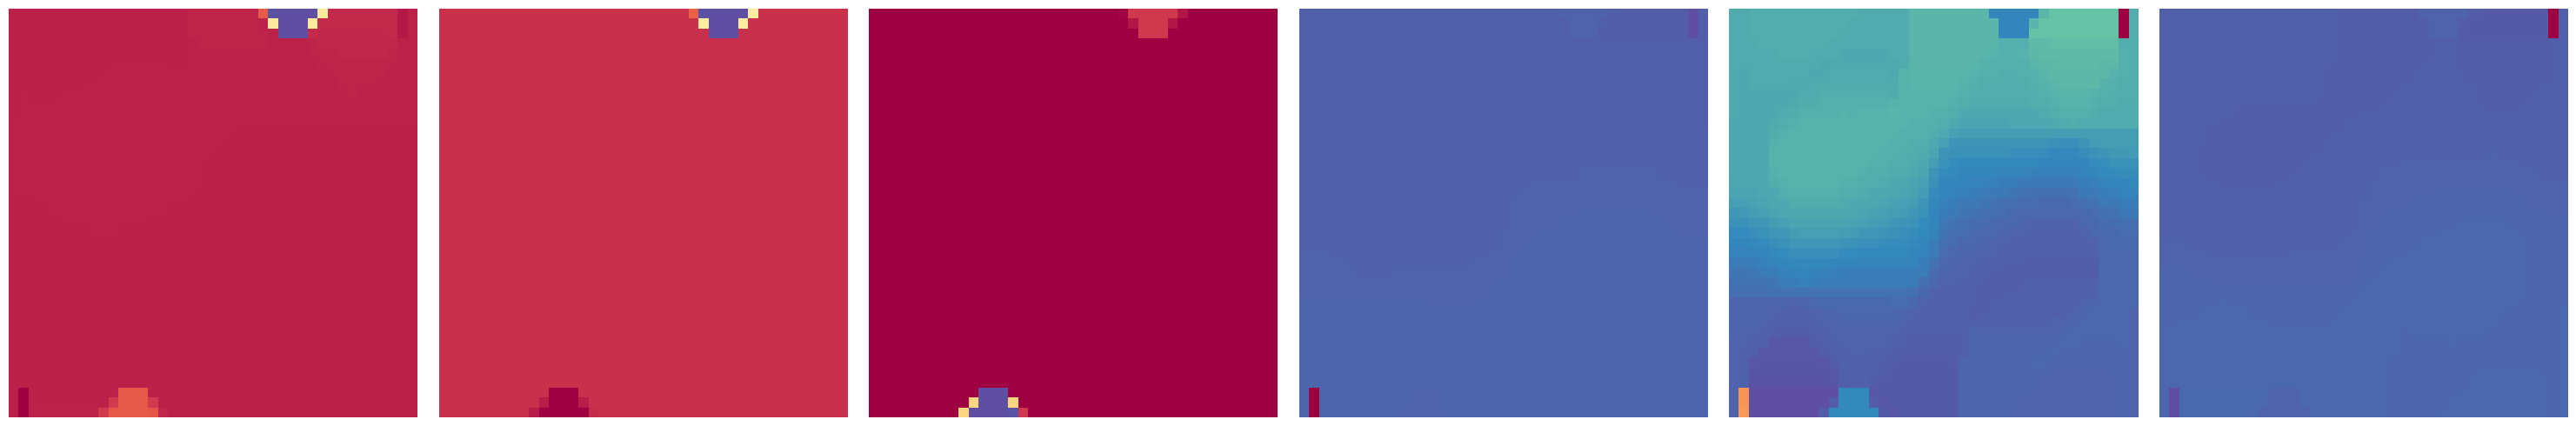

In [17]:
# Representative GL eigenvectors corresponding to segments obtained by LAM
plt.figure(figsize=(30,5))
for k in range(6):
    plt.subplot(1, 6, k+1)
    plt.imshow(v[:,k].reshape((n_row,n_col)), cmap="Spectral", vmin=np.min(v[:,k]), vmax=np.max(v[:,k]))
    plt.axis("off"), plt.tight_layout()

---

#### SIMULATE GRAPH

In [18]:
N = 4096                                                         # Neurons | Default: 30000
prob = 0.1                                                       # Sparsity
eta = 0.01                                                       # Epsilon / Learning rate
epochs = 3000                                                    # Steps
gamma = 0.6                                                      # Inhibition ratio
a_arr = np.arange(-1.5, 1.5, 0.1)                                # Alpha range

start_node = int(int(n_row/2) * n_col + int(n_row/2))            # Center cell of the grid
print('Start node:', start_node)

# Malloc
a_hist, m_hist = [], []
obj_hist = np.zeros([len(a_arr), epochs])

Start node: 840


In [19]:
graph = LAM(N, P, prob, W, gamma, "asym") # Build model

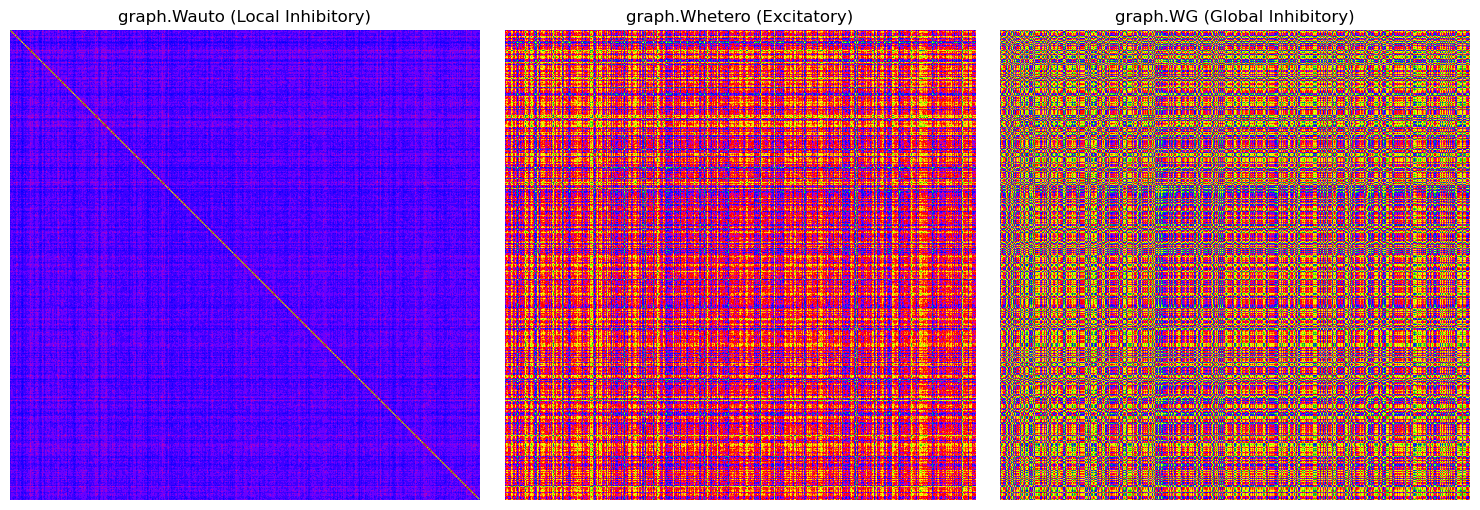

In [20]:
ticker = [graph.Wauto, graph.Whetero, graph.WG]
title = ['graph.Wauto (Local Inhibitory)', 'graph.Whetero (Excitatory)', 'graph.WG (Global Inhibitory)']

fig, axs = plt.subplots(1, len(ticker), figsize=(15,5))
for i in range(len(ticker)):
    axs[i].imshow(ticker[i], cmap='prism')
    axs[i].set_title(title[i])
    axs[i].axis("off")
plt.tight_layout()

In [21]:
# Test simulation (4k = ~25s)
alpha = -0.9
graph._set_weight(alpha)
m_log, obj_log = graph.simulate_single(alpha, eta, epochs, start_node) # Simulate alpha
m = m_log[-1,:]

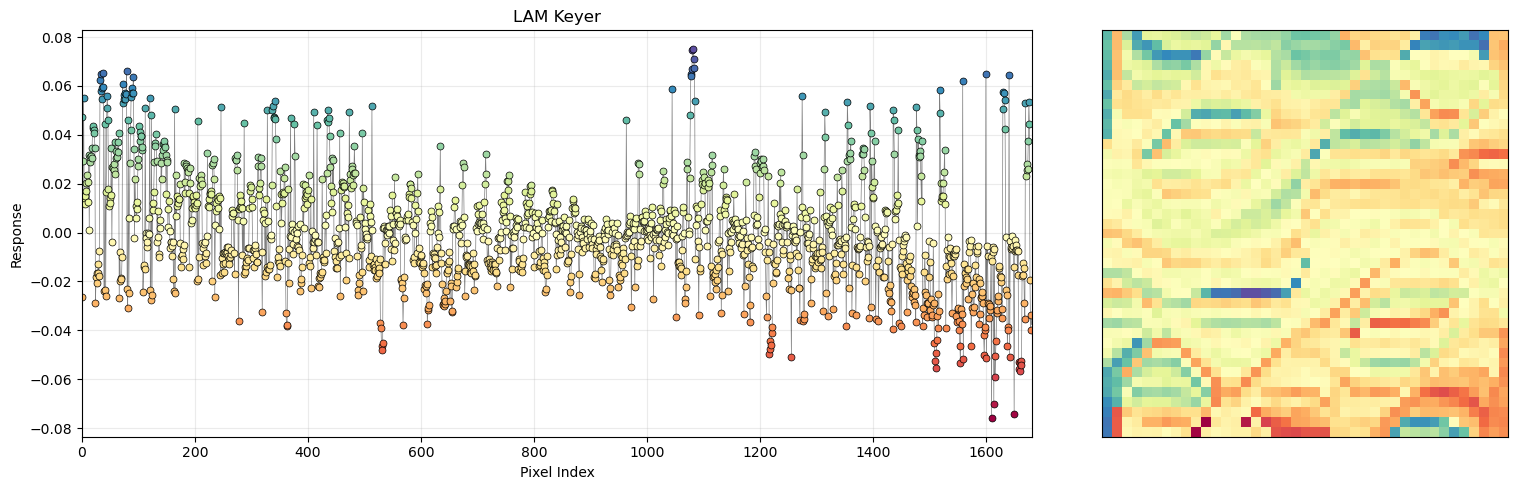

In [22]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(m, 'k', lw=0.5, alpha=0.5)
plot_gradient(m, colormap='Spectral')
plt.title('LAM Keyer')
plt.xlabel('Pixel Index'), plt.ylabel('Response')
plt.xlim([0, m.shape[0]]), plt.grid(alpha=0.25)
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(m.reshape((n_row,n_col)), cmap="Spectral", vmin=np.min(m), vmax=np.max(m))
plt.xticks([]), plt.yticks([])
plt.tight_layout()

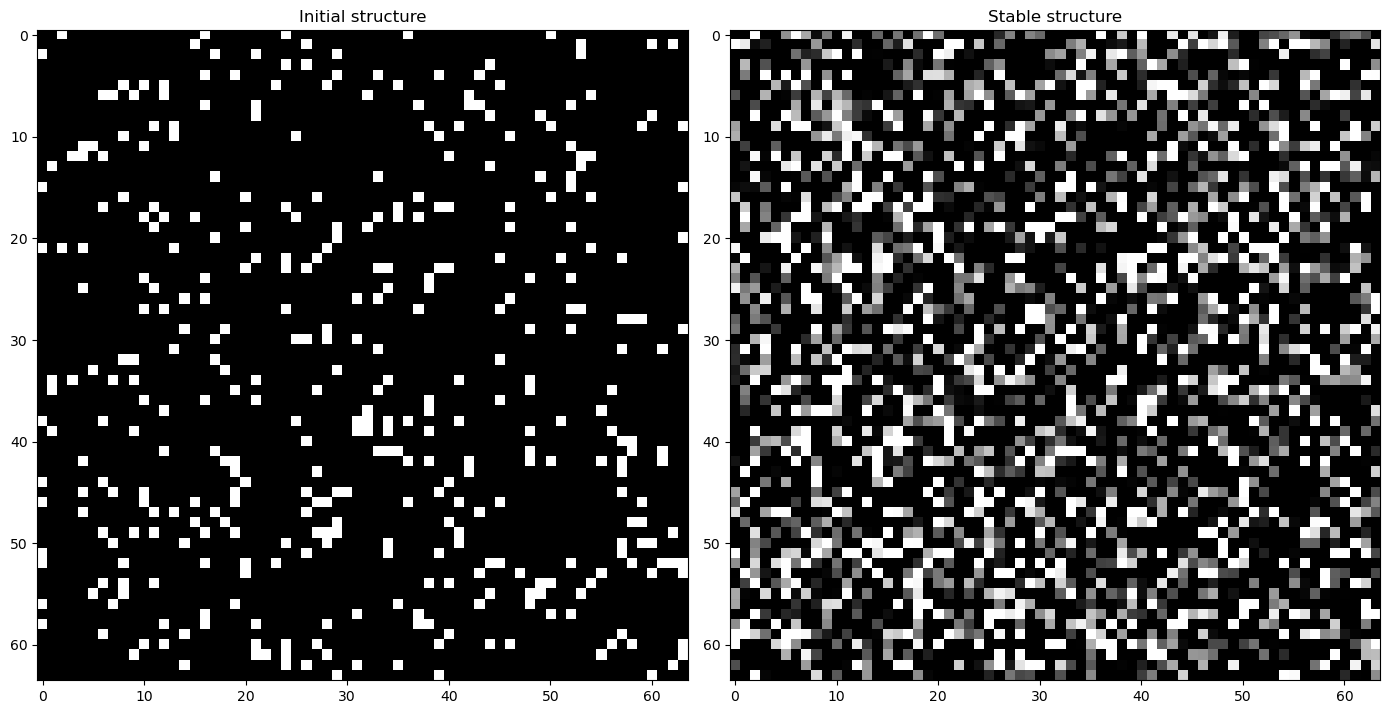

In [23]:
# Network structure pre- and post- activation
plt.figure(figsize=(14,7))
tmp_x = graph.xi[:, start_node].copy()
plt.subplot(1,2,1)
plt.imshow(tmp_x.reshape(64,64), cmap='gray')
plt.title('Initial structure')

plt.subplot(1,2,2)
plt.imshow(graph.x.reshape(64,64), cmap='gray')
plt.title('Stable structure')
plt.tight_layout()

In [24]:
### STOP - HERO SIM BELOW!!!

In [25]:
# 2048 = 5m
# 4196 = 12m
# 8192 = 30m
# 30000 = ??

for a_ind in tqdm(range(len(a_arr))):
    a = np.around(a_arr[a_ind], decimals=1) # Isolate (a) from array
    m_log, obj_log = graph.simulate_single(a, eta, epochs, start_node) # Simulate alpha
    m = m_log[-1,:] # Extract final row (epoch) from m_log

    # Append callbacks
    a_hist.append(a)
    m_hist.append(m)
    obj_hist[a_ind,:] = obj_log

100%|██████████| 30/30 [13:53<00:00, 27.79s/it]


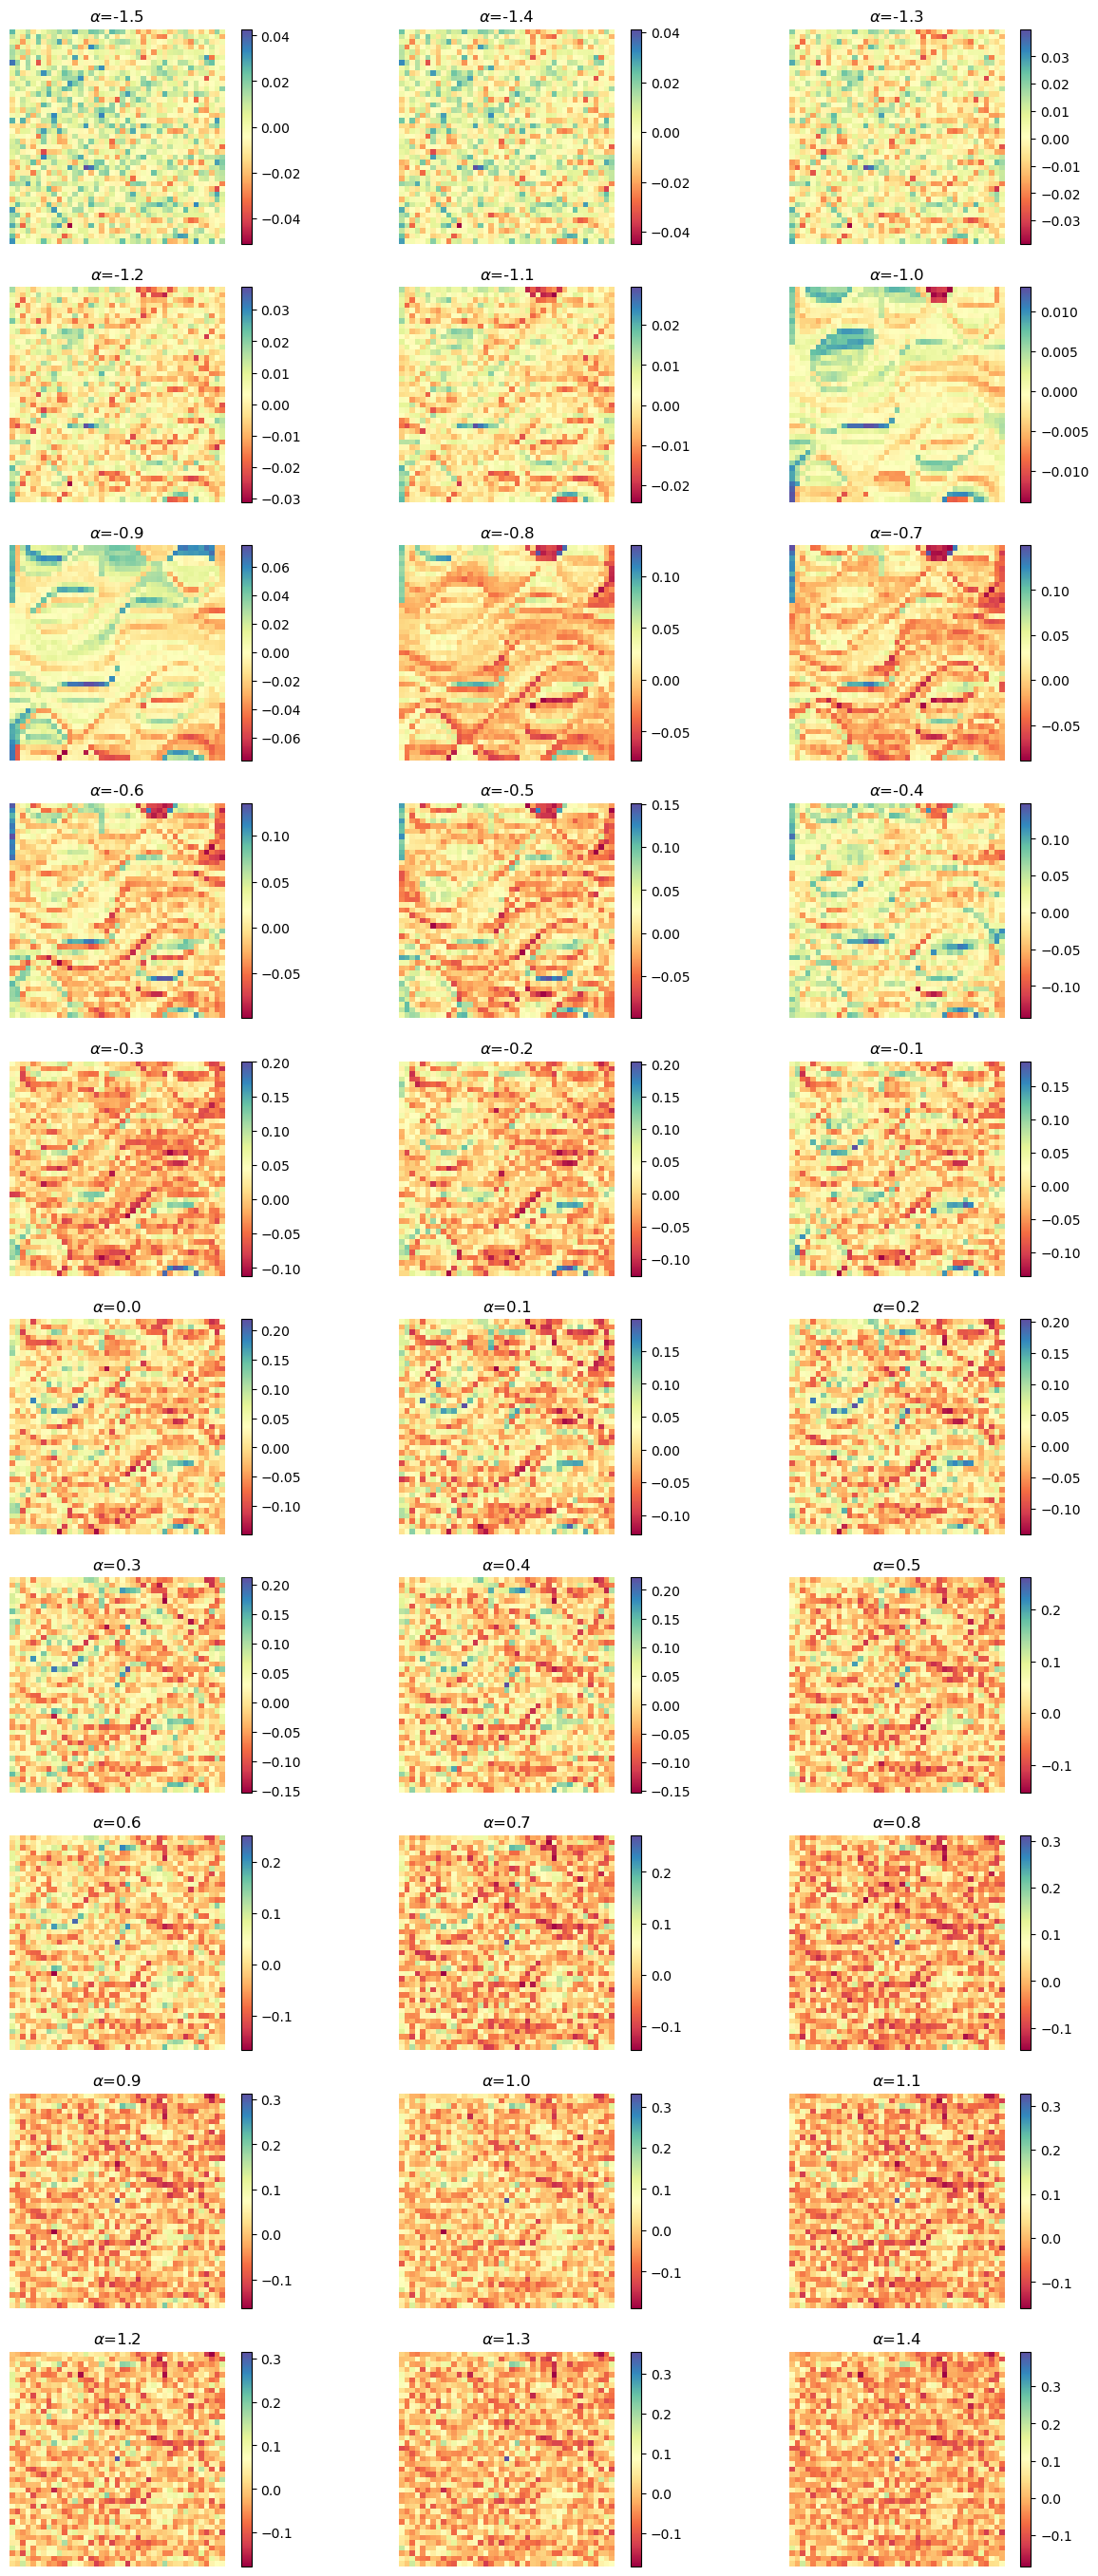

In [26]:
# Pattern overlaps obtained after the simulation of LAM at different *α* values
plt.figure(figsize=(15,70))
for a_ind in range(len(a_arr)):
    a = np.around(a_arr[a_ind], decimals=1)
    m = m_hist[a_ind]

    plt.subplot(20, 3, a_ind+1)
    plt.imshow(m.reshape((n_row,n_col)), cmap="Spectral", vmin=np.min(m), vmax=np.max(m))
    plt.axis("off"), plt.colorbar()
    plt.title(r"$\alpha$="+str(a))

---

#### PLOT STATISTICS

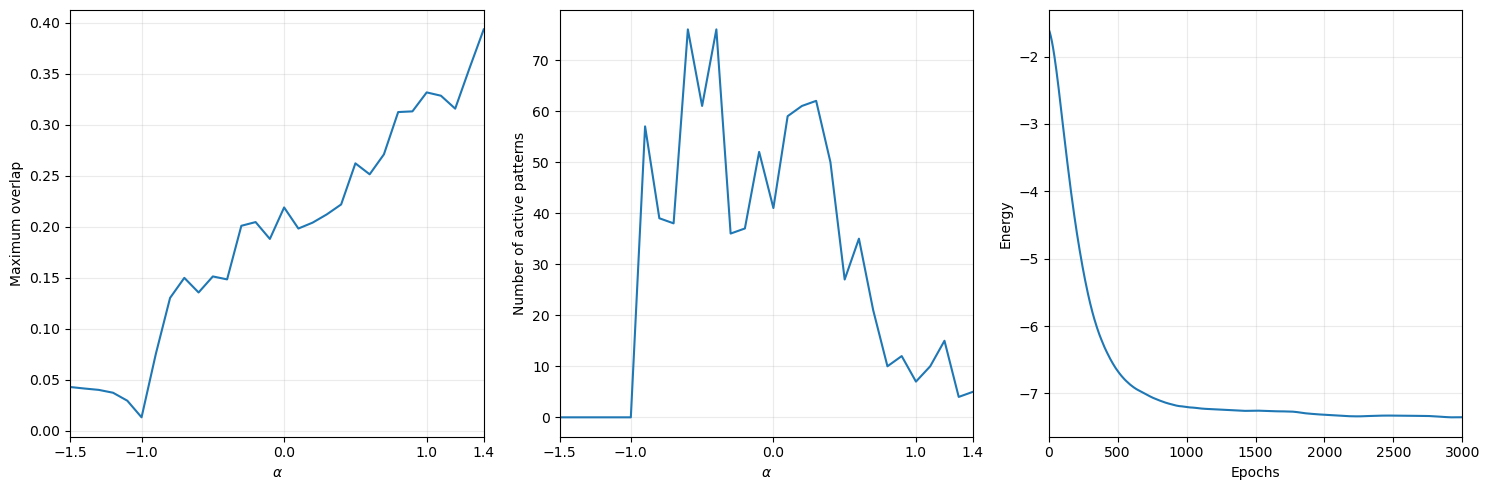

In [27]:
Na = len(a_arr)
max_overlap = np.zeros(Na)
Nactive = np.zeros(Na)

for a_ind in range(Na):
    m = m_hist[a_ind]
    max_m = np.max(m)
    max_overlap[a_ind] = max_m
    Nactive[a_ind] = np.mean(np.sum((m > 0.5*max_m) * (m > 0.05), axis=0))

xlim=[np.min(a_arr), np.max(a_arr)]
xticks=[xlim[0], -1, 0, 1, xlim[1]]

# Max. overlap
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(a_arr, max_overlap)
plt.xlabel(r"$\alpha$"), plt.ylabel("Maximum overlap")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid(alpha=0.25)
plt.tight_layout()

# Number of patterns
plt.subplot(1,3,2)
plt.plot(a_arr, Nactive)
plt.xlabel(r"$\alpha$"), plt.ylabel("Number of active patterns")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid(alpha=0.25)
plt.tight_layout()

# Energy
plt.subplot(1,3,3)
plt.plot(obj_log)
plt.xlabel("Epochs"), plt.ylabel("Energy")
plt.xlim(0,epochs)
plt.grid(alpha=0.25)
plt.tight_layout()

---

#### EXPLAINED VARIANCE

The explained variance ratio in linear regressions of pattern overlaps by various numbers of GL eigenvectors. Colour indicates value of *α*.

(<matplotlib.legend.Legend at 0x7f95195fa970>, None)

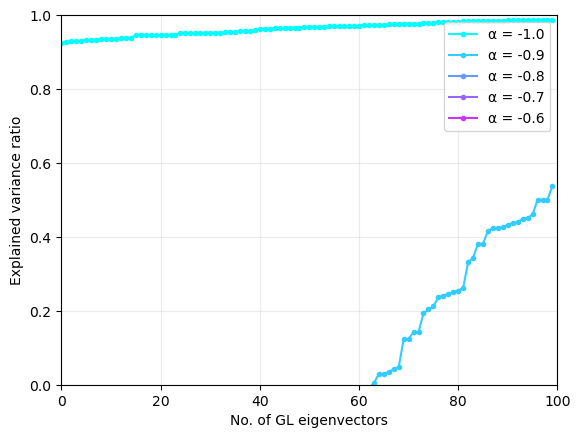

In [28]:
val_ind_pick = [5, 6, 7, 8, 9]
val_arr = [a_arr[i] for i in val_ind_pick]
val_hist = [m_hist[i] for i in val_ind_pick]

p = 100
Rsquare = np.zeros([len(val_arr),p])

# EXPLAINED VAR (GL AND ATTRACTOR)
for val_ind in range(len(val_arr)):
    var = np.var(m_hist[val_ind])
    for i in range(p):
        coeff, res, rank, sing = np.linalg.lstsq(v[:,:i+1], val_hist[val_ind], rcond=None)
        Rsquare[val_ind,i] = 1-np.mean(res) / v.shape[0]/var

# SIMILARITY (OVERLAP AND BASES)
cm = plt.get_cmap("cool")
for i in range(len(val_arr)):
    plt.plot(Rsquare[i,:], ".-", label='α = ' + str(round(val_arr[i],2)), color=cm(i/len(val_arr)))

plt.xlim([0,p]), plt.ylim([0,1])
plt.xlabel("No. of GL eigenvectors")
plt.ylabel("Explained variance ratio")
plt.legend(loc='upper right'), plt.grid(alpha=0.25)